## Prueba de modelos ##

### Version 4: Modelo con 2 DER, planificación anual, granularidad horaria ###

Si el modelo tiene que optimizar el balance por horas, tiene 8640 VD, pero sigue teniendo 2 VD binarias

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandapower as pp

In [4]:
import pyomo.environ as pe

In [5]:
import matplotlib.pyplot as plt

In [6]:
import ModelWriters as mw

In [7]:
import ModelWriters.Scenes as Scenes

In [8]:
import ModelWriters.Resources as Resources

In [125]:
net = pp.create_empty_network() 
b0 = pp.create_bus(net, vn_kv=13.2)

pp.create_ext_grid(net, bus=b0)

#ramal 1
b11 = pp.create_bus(net, vn_kv=13.2)
b12 = pp.create_bus(net, vn_kv=13.2)

pp.create_line(net, from_bus=b0, to_bus=b11, length_km=0.8, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b11, to_bus=b12, length_km=2.1, std_type="NAYY 4x50 SE")

pp.create_sgen(net, b11, p_mw=0.075, q_mvar=0.025, max_p_mw=0.15, max_q_mvar=0.15)
pp.create_load(net, bus=b12, p_mw=0.350)

#ramal 2
b21 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b21, length_km=5.0, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b21, p_mw=0.15, q_mvar=0.00, max_p_mw=0.40, max_q_mvar=0.10)
pp.create_storage(net, bus=b21, p_mw=0.25, q_mvar=0.1, max_e_mwh = 3.0)

#ramal 3
b31 = pp.create_bus(net, vn_kv=13.2)
b32 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b31, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b31, to_bus=b32, length_km=1.5, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b31, p_mw=0.08, q_mvar=0.00, max_p_mw=0.30, max_q_mvar=0.10)
pp.create_load(net, bus=b32, p_mw=0.85, q_mvar=0.33)


#ramal 4
b41 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b41, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_load(net, bus=b41, p_mw=0.22, q_mvar=0.05)
#pp.create_storage(net, bus=b41, p_mw=0.5, q_mvar=0.1, max_e_mwh = 5.0)



2

In [114]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar
0,None,1,0.075,0.025,NaN,1.0,True,wye,True,0.15,0.15
1,None,3,0.150,0.000,NaN,1.0,True,wye,True,0.40,0.10
2,None,4,0.080,0.000,NaN,1.0,True,wye,True,0.30,0.10


In [115]:
 pp.runpp(net)

In [ ]:
print(net.res_bus.vm_pu)
print(net.res_line)

In [ ]:
print(net)

## Construcción de Escenarios

In [116]:
#s = Scenes.SceneBuilder(years = 4, subperiods = 1, days_in_subperiods = 1, dt=24, growth_rate = 0.025, discount_rate = 0.05)
#s = Scenes.SceneBuilder(years = 4, subperiods = 1, days_in_subperiods = 1, dt=12, growth_rate = 0.025, discount_rate = 0.05)
#s = Scenes.SceneBuilder(years = 20, subperiods = 12, days_in_subperiods = 1, growth_rate = 0.025, discount_rate = 0.03)
s = Scenes.SceneBuilder(years = 20, subperiods = 12, days_in_subperiods = 1, growth_rate = 0.025, discount_rate = 0.03)
scenes = s.build_scenes()
scenes

,year,day,dd,hour,dt,growth,discount,solar_irradiance,wind_speed
0,0.0,0.0,30.416667,0.0,1.0,1.00000,1.000000,0.0,1.427512
1,0.0,0.0,30.416667,1.0,1.0,1.00000,1.000000,0.0,2.868278
2,0.0,0.0,30.416667,2.0,1.0,1.00000,1.000000,0.0,2.842204
3,0.0,0.0,30.416667,3.0,1.0,1.00000,1.000000,0.0,3.246452
4,0.0,0.0,30.416667,4.0,1.0,1.00000,1.000000,0.0,3.728415
...,...,...,...,...,...,...,...,...,...
5755,19.0,330.0,30.416667,19.0,1.0,1.59865,0.570286,0.0,11.709704
5756,19.0,330.0,30.416667,20.0,1.0,1.59865,0.570286,0.0,10.357286
5757,19.0,330.0,30.416667,21.0,1.0,1.59865,0.570286,0.0,10.430824
5758,19.0,330.0,30.416667,22.0,1.0,1.59865,0.570286,0.0,11.489138


## Model Construction

Construccion automatica del modelo
Es un modelo de dimensionamiento de 3 DERs (WT+PV)

In [166]:
model_writer = mw.MultiBusbarModelWriter(net, scenes, soft_limit_coefficient = 2.0)

In [167]:
net.ext_grid['model'][0] = Resources.ExtGrid('SET', pr_mw = 5.0, peak_value=200, valley_value=120, rest_value=160)
#net.ext_grid['model'][0] = Resources.ExtGrid('SET', pr_mw = 5.0, peak_value=2000, valley_value=1500, rest_value=1000)

In [168]:
net.load['model'][0] = Resources.Load('Tornquinst', pr_mw = 0.35)
net.load['model'][1] = Resources.Load('Bell Ville', pr_mw = 0.85)
net.load['model'][2] = Resources.Load('City Bell', pr_mw = 0.22)

In [169]:
net.sgen['model'][0] = Resources.PVGenerator('PV1', ic_0_mu = 0.0, ic_1_mu = 1.02e6, oc_0_mu = 1.02, oc_1_mu = 0.0)
net.sgen['model'][1] = Resources.WTGeneratorDiscrete('WT1', unit_size_mw = 0.19, unit_cost_mu = 541e3, oc_0_mu = 0.00, oc_1_mu = 1.70)
net.sgen['model'][2] = Resources.PVGeneratorDiscrete('PV2', unit_size_mw = 0.05, unit_cost_mu = 51e3, oc_0_mu = 0.03, oc_1_mu = 0.0)

In [170]:
net.storage['model'][0] = Resources.Storage('ST1', ic_1_mu = 554e3, ic_1_mu_cap = 330e3, oc_1_mu = 2.28*4, eta_bb = 0.8, sigma = 2.1e-3)

## Resolution

In [171]:
model = model_writer.create_model()

In [172]:
#model.pprint()

In [173]:
#solver_manager = pe.SolverManagerFactory('neos')
#result_obj = solver_manager.solve(model.model, opt='cplex')

opt = pe.SolverFactory('cplex')
#opt = pe.SolverFactory('glpk')
result_obj= opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\jmsar\AppData\Local\Temp\tmpakio6pnm.cplex.log' open.
CPLEX> Problem 'C:\Users\jmsar\AppData\Local\Temp\tmppj6o250z.pyomo.lp' read.
Read time = 1.47 sec. (39.26 ticks)
CPLEX> Problem name         : C:\Users\jmsar\AppData\Local\Temp\tmppj6o250z.pyomo.lp
Objective sense      : Minimize
Variables            :  311052  [Nneg: 195846,  Box: 40320,  Free: 5760,
                                 Binary: 69124,  General Integer: 2]
Objective nonzeros   :   51846
Linear constraints   :  328328  [Less: 178565,  Equal: 149763]
  Nonzeros           :  777575
  RHS nonzeros       :  155521

Variabl

In [134]:
model_writer.backconfigure_network()

In [135]:
model_writer.net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,model
0,None,1,0.075,0.025,NaN,1.0,True,wye,True,0.54922,0.27461,Resource: PV1
1,None,3,0.150,0.000,NaN,1.0,True,wye,True,0.00000,0.00000,Resource: WT1
2,None,4,0.080,0.000,NaN,1.0,True,wye,True,3.30000,1.65000,Resource: PV2


In [136]:
net.sgen['model'][2].units.value

66.0

In [137]:
model_writer.net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,model
0,None,3,0.25,0.1,NaN,NaN,0.0,7.498764,1.0,True,None,Resource: ST1


In [138]:
Resultados = model_writer.get_scenes_results()

In [139]:
Resultados

,SET_p_mw,Tornquinst_p_mw,Bell Ville_p_mw,City Bell_p_mw,PV1_p_mw,WT1_p_mw,PV2_p_mw,ST1_p_mw,ST1_soc_mwh,L 0_1_pf_mw,...,L 1_2_pf_mw,L 1_2_ep_mw,L 0_3_pf_mw,L 0_3_ep_mw,L 0_4_pf_mw,L 0_4_ep_mw,L 4_5_pf_mw,L 4_5_ep_mw,L 0_6_pf_mw,L 0_6_ep_mw
0,0.366886,-0.095858,-0.219229,-0.051799,0.0,0.0,0.0,0.000000,0.000000,-0.095858,...,-0.095858,0.0,0.000000,0.0,-0.219229,0.0,-0.219229,0.0,-0.051799,0.0
1,0.333229,-0.072669,-0.207404,-0.053157,0.0,0.0,0.0,0.000000,0.000000,-0.072669,...,-0.072669,0.0,0.000000,0.0,-0.207404,0.0,-0.207404,0.0,-0.053157,0.0
2,1.959462,-0.078928,-0.169177,-0.042871,0.0,0.0,0.0,-1.668485,1.334788,-0.078928,...,-0.078928,0.0,-1.668485,0.0,-0.169177,0.0,-0.169177,0.0,-0.042871,0.0
3,2.085612,-0.086667,-0.238046,-0.047140,0.0,0.0,0.0,-1.713758,2.702992,-0.086667,...,-0.086667,0.0,-1.713758,0.0,-0.238046,0.0,-0.238046,0.0,-0.047140,0.0
4,2.018256,-0.084291,-0.168782,-0.051424,0.0,0.0,0.0,-1.713758,4.068322,-0.084291,...,-0.084291,0.0,-1.713758,0.0,-0.168782,0.0,-0.168782,0.0,-0.051424,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,0.750327,-0.659836,-1.351904,-0.452345,0.0,0.0,0.0,1.713758,3.091257,-0.659836,...,-0.659836,0.0,1.713758,0.0,-1.351904,0.0,-1.351904,0.0,-0.452345,0.0
5756,0.680587,-0.676667,-1.364412,-0.353266,0.0,0.0,0.0,1.713758,1.713758,-0.676667,...,-0.676667,0.0,1.713758,0.0,-1.364412,0.0,-1.364412,0.0,-0.353266,0.0
5757,1.869041,-0.571957,-1.836337,-0.410836,0.0,0.0,0.0,0.950089,0.950089,-0.571957,...,-0.571957,0.0,0.950089,0.0,-1.836337,0.0,-1.836337,0.0,-0.410836,0.0
5758,0.274441,-0.204537,-0.478742,-0.117880,0.0,0.0,0.0,0.526719,0.526719,-0.204537,...,-0.204537,0.0,0.526719,0.0,-0.478742,0.0,-0.478742,0.0,-0.117880,0.0


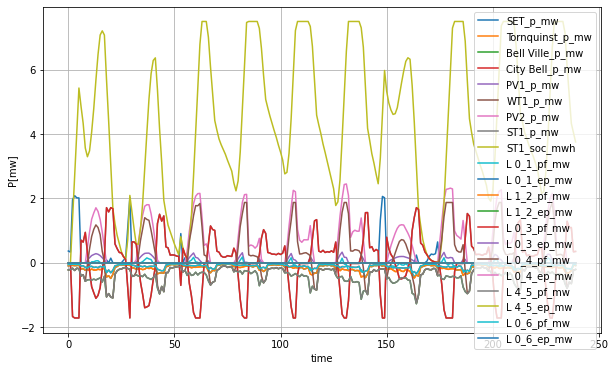

In [140]:
# Set the plot curve with markers and a title
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(10,6)
#a=180*24
#b=360
#b=180*24+5*24
a=0
b=240
for col in Resultados:
    ax.plot(Resultados[col][a:b], label = col)

ax.set_xlabel('time')
ax.set_ylabel('P[mw]')

ax.legend()

ax.grid(True)


plt.show()

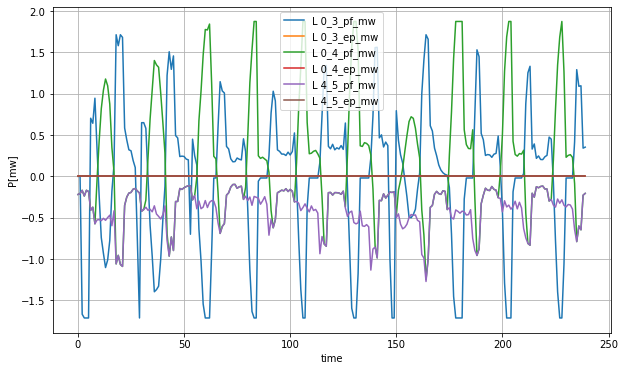

In [142]:
# Set the plot curve with markers and a title
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(10,6)
#a=180*24
#b=360
#b=180*24+5*24
a=0
b=240

selected_cols = ['L 0_1_pf_mw', 'L 0_1_ep_mw', 'L 1_2_pf_mw', 'L 1_2_ep_mw', 'L 0_6_pf_mw', 'L 0_6_ep_mw']
selected_cols = ['L 0_3_pf_mw', 'L 0_3_ep_mw', 'L 0_4_pf_mw', 'L 0_4_ep_mw', 'L 4_5_pf_mw', 'L 4_5_ep_mw']
for col in selected_cols:
    ax.plot(Resultados[col][a:b], label = col)

ax.set_xlabel('time')
ax.set_ylabel('P[mw]')

ax.legend()

ax.grid(True)


plt.show()